# N-Gaussians  

In [1]:
import torch
import matplotlib.pyplot as plt

from markov_bridges.configs.config_classes.generative_models.cfm_config import CFMConfig
from markov_bridges.configs.config_classes.data.basics_configs import GaussiansConfig
from markov_bridges.configs.config_classes.trainers.trainer_config import CFMTrainerConfig
from markov_bridges.configs.config_classes.networks.continuous_network_config import DeepMLPConfig
from markov_bridges.configs.config_classes.pipelines.pipeline_configs import CFMPipelineConfig
from markov_bridges.models.trainers.cfm_trainer import CFMTrainer
from markov_bridges.utils.experiment_files import ExperimentFiles

model_config = CFMConfig()
model_config.data = GaussiansConfig(target_continuous_type="Ngaussian", 
                                    number_of_gaussians=4,
                                    has_context_discrete=True,
                                    has_target_discrete=False,
                                    batch_size=128,
                                    total_data_size=66000,
                                    train_data_size=60000,
                                    test_data_size=6000,)

model_config.continuous_network = DeepMLPConfig(time_embed_dim=16, dropout=0.0)

model_config.trainer = CFMTrainerConfig(number_of_epochs=10, 
                                        debug=False, 
                                        learning_rate=1e-4)
model_config.trainer.device = "cuda:0"
model_config.trainer.paralellize_gpu = False
model_config.trainer.metrics = []
model_config.thermostat.gamma = 0.01
model_config.pipeline = CFMPipelineConfig(number_of_steps=200)

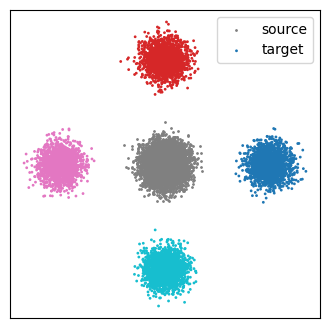

In [7]:
from markov_bridges.data.gaussians2D_dataloaders import GaussiansDataloader

dataloader = GaussiansDataloader(model_config.data)
data = dataloader.get_data_sample(sample_size=8000, train=True)

plt.figure(figsize=(4, 4))
plt.scatter(data.source_continuous[:, 0], data.source_continuous[:, 1], s=1, c='gray', label="source")
plt.scatter(data.target_continuous[:, 0], data.target_continuous[:, 1], s=1, c=data.context_discrete, cmap="tab10", label="target")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.legend()
plt.show()

In [2]:
experiment_files = ExperimentFiles(experiment_name="cfm_context", experiment_type="Ngaussians") 
trainer = CFMTrainer(config=model_config, experiment_files=experiment_files)
trainer.train()

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
Ngaussians
cfm_context
None
# ==================================================
# Number of Epochs 10
# ==================================================


Epoch 10, Loss: 0.0166: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


({'model': DeepMLP(
    (act_fn): ReLU()
    (discrete_embedding): Embedding(4, 16)
    (encoding_model): Sequential(
      (0): Linear(in_features=34, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (continuous_head): Linear(in_features=128, out_features=2, bias=True)
  ),
  'best_loss': 0.016344357004508057,
  'training_loss': 0.016602472974054976,
  'test_loss': 0.016597368437400523,
  'all_training_loss': [0.6494407057762146,
   0.551101803779602,
   0.585962176322937,
   0.5091420412063599,
   0.4296179413795471,
   0.5191757678985596,
   0

In [3]:
from markov_bridges.models.generative_models.cfm import CFM
from markov_bridges.data.gaussians2D_dataloaders import GaussiansDataloader

path = '/home/df630/markov_bridges/results/cfm_context/Ngaussians/1722553471'

cfm = CFM(experiment_dir=path)
dataloader = GaussiansDataloader(model_config.data)

trajectories = []
context_discrete = []

for databatch in dataloader.test():
    sample = cfm.pipeline.generate_sample(databatch, return_path=True)
    trajectories.append(sample.trajectories.detach().cpu())
    context_discrete.append(sample.context_discrete.detach().cpu())

trajectories = torch.cat(trajectories, dim=0)
context_discrete = torch.cat(context_discrete, dim=0)


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


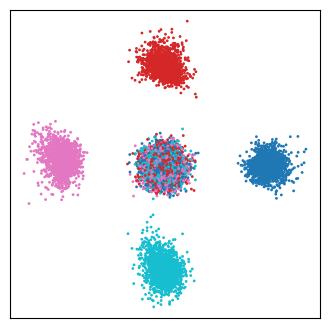

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.scatter(trajectories[:,0,0], trajectories[:,0,1], s=1, c=context_discrete, cmap="tab10")
plt.scatter(trajectories[:,-1,0], trajectories[:,-1,1],  s=1, c=context_discrete, cmap="tab10")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()